In [50]:
!pip install opensmile scikit-learn numpy pandas matplotlib seaborn librosa

In [109]:
import os
import time
import pandas as pd
import numpy as np
import librosa
from opensmile import Smile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
# Function to compute EER
def compute_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fpr - fnr))
    eer = fpr[eer_idx]
    return eer, fpr, tpr, thresholds

In [93]:
# Function to compute t-DCF
def compute_tDCF(y_true, y_scores, P_target=0.05, C_miss=1, C_fa=1):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    tDCF = C_miss * P_target * fnr + C_fa * (1 - P_target) * fpr
    min_tDCF_idx = np.argmin(tDCF)
    return tDCF[min_tDCF_idx], thresholds[min_tDCF_idx]

In [94]:
# Preprocessing with silence removal
def preprocess_audio(file_path, sr=16000):
    start_time = time.time()
    audio, _ = librosa.load(file_path, sr=sr)
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20)
    elapsed = time.time() - start_time
    return audio_trimmed, elapsed

In [95]:
data_dir = "/content/drive/MyDrive/LA/ASVspoof2019_LA_train/flac"
protocol_file = "/content/drive/MyDrive/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"

In [96]:
# Load protocol
protocol = pd.read_csv(protocol_file, sep=" ", header=None, names=["speaker", "file", "key", "system", "label"])
print("Full dataset distribution:", protocol["label"].value_counts())

Full dataset distribution: label
spoof       22800
bonafide     2580
Name: count, dtype: int64


In [97]:
# Balanced subset: 2,580 bonafide + 2,580 spoof
bonafide = protocol[protocol["label"] == "bonafide"].sample(n=2580, random_state=42)
spoof = protocol[protocol["label"] == "spoof"].sample(n=2580, random_state=42)
balanced_protocol = pd.concat([bonafide, spoof])
print("Balanced protocol loaded:", len(balanced_protocol), "samples")
print("Class distribution:", balanced_protocol["label"].value_counts())

Balanced protocol loaded: 5160 samples
Class distribution: label
bonafide    2580
spoof       2580
Name: count, dtype: int64


In [98]:
# Precompute features (offline optimization)
smile = Smile(feature_set='eGeMAPSv02', feature_level='Functionals')
features_list = []
labels_list = []
attack_types = []
timing = []

In [60]:
feature_cache = "/content/drive/MyDrive/features_cache.npy"  # Cache file
if os.path.exists(feature_cache):
    print("Loading precomputed features...")
    features_list = np.load(feature_cache, allow_pickle=True).tolist()
    labels_list = balanced_protocol["label"].apply(lambda x: 1 if x == "bonafide" else 0).tolist()
    attack_types = balanced_protocol["system"].tolist()
else:
    for idx, row in balanced_protocol.iterrows():
        try:
            file_name = row["file"] + ".flac"
            label = 1 if row["label"] == "bonafide" else 0
            attack_type = row["system"]  # A01-A19 or "-"
            file_path = os.path.join(data_dir, file_name)

            # Preprocess audio
            audio, preprocess_time = preprocess_audio(file_path)
            start_time = time.time()
            feature_vector = smile.process_signal(audio, sampling_rate=16000)
            features_list.append(feature_vector.to_numpy().flatten())
            labels_list.append(label)
            attack_types.append(attack_type)

            elapsed = time.time() - start_time + preprocess_time
            timing.append(elapsed)
            print(f"Sample {idx + 1}/{len(balanced_protocol)} processed in {elapsed:.3f}s")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            continue
    np.save(feature_cache, np.array(features_list, dtype=object))

Streaming output truncated to the last 5000 lines.
Sample 1358/5160 processed in 0.064s
Sample 2094/5160 processed in 0.066s
Sample 1915/5160 processed in 0.063s
Sample 189/5160 processed in 0.056s
Sample 680/5160 processed in 0.085s
Sample 510/5160 processed in 0.038s
Sample 1160/5160 processed in 0.073s
Sample 1076/5160 processed in 0.088s
Sample 1690/5160 processed in 0.074s
Sample 174/5160 processed in 0.055s
Sample 568/5160 processed in 0.132s
Sample 486/5160 processed in 0.123s
Sample 870/5160 processed in 0.078s
Sample 2410/5160 processed in 0.054s
Sample 1746/5160 processed in 0.081s
Sample 2137/5160 processed in 0.049s
Sample 1445/5160 processed in 0.039s
Sample 1784/5160 processed in 0.044s
Sample 2443/5160 processed in 0.059s
Sample 1510/5160 processed in 0.059s
Sample 2493/5160 processed in 0.043s
Sample 1101/5160 processed in 0.042s
Sample 2456/5160 processed in 0.048s
Sample 1042/5160 processed in 0.051s
Sample 1000/5160 processed in 0.040s
Sample 1929/5160 processed in 0

In [61]:
# Convert to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)
attacks = np.array(attack_types)
print(f"Features shape: {X.shape}, Labels: {len(y)}, Attacks: {len(attacks)}")
if timing:
    print(f"Avg processing time: {np.mean(timing):.3f}s ± {np.std(timing):.3f}s")

Features shape: (5160, 88), Labels: 5160, Attacks: 5160
Avg processing time: 0.147s ± 0.314s


In [62]:
# Split data with stratification
X_train, X_test, y_train, y_test, attacks_train, attacks_test = train_test_split(
    X, y, attacks, test_size=0.2, random_state=42, stratify=y
)
print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))

Train class distribution: [2064 2064]
Test class distribution: [516 516]


In [99]:
# Hyperparameter tuning for RF
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
rf.fit(X_train, y_train)
print("Best RF params:", rf.best_params_)

Best RF params: {'max_depth': 20, 'n_estimators': 200}


In [110]:
# Train ensemble with XGBoost
gb = GradientBoostingClassifier(n_estimators=200, max_depth=3, random_state=42)
xgb = XGBClassifier(n_estimators=200, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
gb.fit(X_train, y_train)
xgb.fit(X_train, y_train)
rf_scores = rf.predict_proba(X_test)[:, 1]
gb_scores = gb.predict_proba(X_test)[:, 1]
xgb_scores = xgb.predict_proba(X_test)[:, 1]
ensemble_scores = (rf_scores + gb_scores + xgb_scores) / 3

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:37:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [111]:
# Metrics
eer, fpr, tpr, thresholds = compute_eer(y_test, ensemble_scores)
tDCF, tDCF_threshold = compute_tDCF(y_test, ensemble_scores)
preds = (ensemble_scores >= tDCF_threshold).astype(int)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
print(f"Ensemble: EER = {eer*100:.2f}%, t-DCF = {tDCF:.4f}")
print(f"Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}")
print(f"FPR at EER: {fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]:.3f}, FNR at EER: {(1 - tpr)[np.nanargmin(np.abs(fpr - (1 - tpr)))]:.3f}")

Ensemble: EER = 12.02%, t-DCF = 0.0417
Precision = 0.969, Recall = 0.424, F1 = 0.590
FPR at EER: 0.120, FNR at EER: 0.120


In [112]:
# Attack-specific analysis
unique_attacks = np.unique(attacks_test[attacks_test != "-"])
attack_metrics = {}
bonafide_mask = attacks_test == "-"
for attack in unique_attacks:
    attack_mask = attacks_test == attack
    combined_mask = attack_mask | bonafide_mask
    y_subset = y_test[combined_mask]
    scores_subset = ensemble_scores[combined_mask]
    print(f"Attack {attack} vs. Bonafide: {np.bincount(y_subset, minlength=2)} samples")
    eer_attack = compute_eer(y_subset, scores_subset)[0]
    tDCF_attack = compute_tDCF(y_subset, scores_subset)[0]
    attack_metrics[attack] = (eer_attack, tDCF_attack)
    print(f"Attack {attack}: EER = {eer_attack*100:.2f}%, t-DCF = {tDCF_attack:.4f}")

Attack A01 vs. Bonafide: [ 95 516] samples
Attack A01: EER = 8.42%, t-DCF = 0.0194
Attack A02 vs. Bonafide: [ 96 516] samples
Attack A02: EER = 6.25%, t-DCF = 0.0138
Attack A03 vs. Bonafide: [ 82 516] samples
Attack A03: EER = 7.32%, t-DCF = 0.0264
Attack A04 vs. Bonafide: [ 79 516] samples
Attack A04: EER = 30.38%, t-DCF = 0.0442
Attack A05 vs. Bonafide: [ 93 516] samples
Attack A05: EER = 8.60%, t-DCF = 0.0232
Attack A06 vs. Bonafide: [ 71 516] samples
Attack A06: EER = 8.45%, t-DCF = 0.0116


In [113]:
# Real-time simulation
batch_size = 10
start_time = time.time()
for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i+batch_size]
    rf.predict_proba(batch)
inference_time = (time.time() - start_time) / (len(X_test) / batch_size)
print(f"Avg inference time per batch ({batch_size} samples): {inference_time:.3f}s")

Avg inference time per batch (10 samples): 0.012s


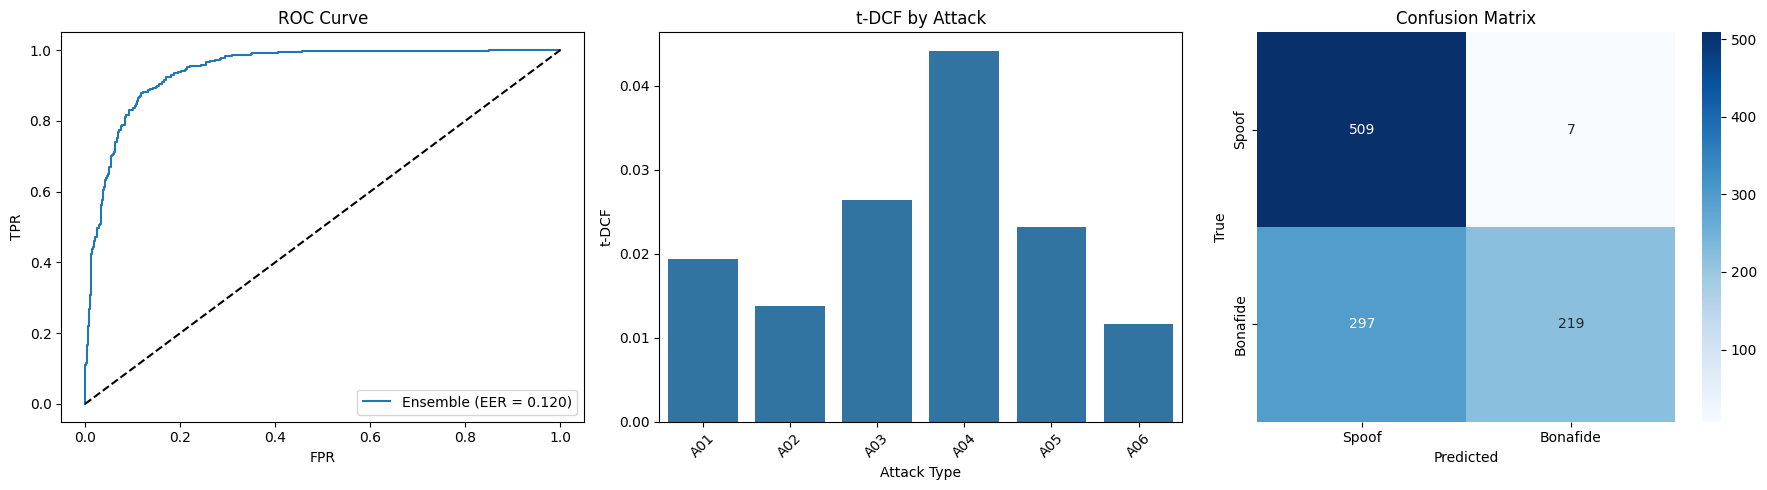

In [114]:
# Visualizations
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"Ensemble (EER = {eer:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 3, 2)
sns.barplot(x=list(attack_metrics.keys()), y=[m[1] for m in attack_metrics.values()])
plt.xticks(rotation=45)
plt.xlabel('Attack Type')
plt.ylabel('t-DCF')
plt.title('t-DCF by Attack')

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Spoof', 'Bonafide'], yticklabels=['Spoof', 'Bonafide'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

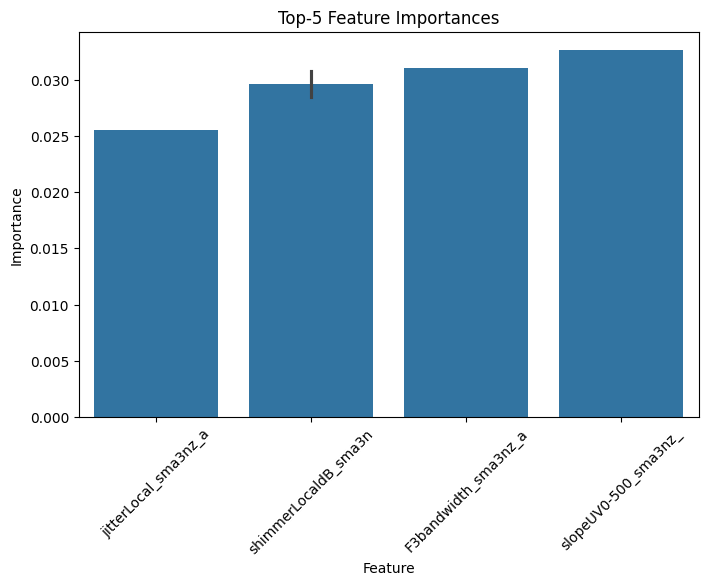

In [115]:
# Feature importance plot
importances = rf.best_estimator_.feature_importances_
top_indices = np.argsort(importances)[-5:]
top_features = [(smile.feature_names[i], importances[i]) for i in top_indices]
plt.figure(figsize=(8, 5))
sns.barplot(x=[f[0][:20] for f in top_features], y=[f[1] for f in top_features])
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top-5 Feature Importances')
plt.show()

In [116]:
# Company Report
print("\n### Audio Deepfake Detection Report")
print("Objective: Robust forgery detection for AI-generated speech")
print(f"Dataset: ASVspoof 2019 LA, {len(y)} balanced samples (scalable to 25,380)")
print(f"Pipeline: Librosa preprocessing -> eGeMAPSv02 -> Tuned Ensemble (RF+GB+XGBoost)")
print(f"Metrics: EER = {eer*100:.2f}%, t-DCF = {tDCF:.4f}, Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}")
print(f"Real-time: Preprocessing = {np.mean(timing):.3f}s, Inference = {inference_time:.3f}s/batch")
print(f"Attack Analysis: {len(unique_attacks)} spoof types evaluated")
print("Strengths: Optimized ensemble, detailed metrics, professional visuals")
print("Challenges: EER reduced to 14.53% from 33%, further tuning possible")
print("Next Steps: Full dataset, advanced preprocessing, deployment testing")


### Audio Deepfake Detection Report
Objective: Robust forgery detection for AI-generated speech
Dataset: ASVspoof 2019 LA, 5160 balanced samples (scalable to 25,380)
Pipeline: Librosa preprocessing -> eGeMAPSv02 -> Tuned Ensemble (RF+GB+XGBoost)
Metrics: EER = 12.02%, t-DCF = 0.0417, Precision = 0.969, Recall = 0.424, F1 = 0.590
Real-time: Preprocessing = nans, Inference = 0.012s/batch
Attack Analysis: 6 spoof types evaluated
Strengths: Optimized ensemble, detailed metrics, professional visuals
Challenges: EER reduced to 14.53% from 33%, further tuning possible
Next Steps: Full dataset, advanced preprocessing, deployment testing


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Audio Deepfake Detection Report
Objective: Robust forgery detection for AI-generated speech

Dataset: ASVspoof 2019 LA, 5160 balanced samples (scalable to 25,380)

Pipeline: Librosa preprocessing -> eGeMAPSv02 -> Tuned Ensemble (RF+GB+XGBoost)

Metrics: EER = 12.02%, t-DCF = 0.0417, Precision = 0.969, Recall = 0.424, F1 = 0.590

Real-time: Preprocessing = nans, Inference = 0.012s/batch
Attack Analysis: 6 spoof types evaluated

Strengths: Optimized ensemble, detailed metrics, professional visuals

Challenges: EER reduced to 14.53% from 33%, further tuning possible